In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=0026539ada4950d14c19c51d9dd6a3e7a7813d820e10e4af0ae04d34c48d5e18
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [2]:
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from shutil import copyfile
from os import listdir
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [3]:
for i in os.listdir('/kaggle/input/brain-tumor-classification-mri/Training'):
    print(len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Training/'+i)))

395
827
822
826


In [4]:
for i in os.listdir('/kaggle/input/brain-tumor-classification-mri/Testing'):
    print(len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Testing/'+i)))

105
74
115
100


In [5]:
gt = len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor'))
mt = len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor'))
nt = len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Training/no_tumor'))
pt = len(os.listdir('/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor'))
t = (gt+mt+nt+pt)
gt_prec = (gt*100.0)/t
mt_prec = (mt*100.0)/t
nt_prec = (nt*100.0)/t
pt_prec = (pt*100.0)/t
print(f"Number of examples: {t}")
print(f"Percentage of glioma tumor examples: {gt_prec}%, number of pos examples: {gt}") 
print(f"Percentage of meningioma tumor examples: {mt_prec}%, number of neg examples: {mt}") 
print(f"Percentage of no tumor examples: {nt_prec}%, number of pos examples: {nt}") 
print(f"Percentage of pituitary tumor examples: {pt_prec}%, number of neg examples: {pt}") 

Number of examples: 2870
Percentage of glioma tumor examples: 28.78048780487805%, number of pos examples: 826
Percentage of meningioma tumor examples: 28.641114982578397%, number of neg examples: 822
Percentage of no tumor examples: 13.763066202090592%, number of pos examples: 395
Percentage of pituitary tumor examples: 28.81533101045296%, number of neg examples: 827


In [6]:
train_labels = []
test_labels = []
train_img = []
test_img = []
path_train = '/kaggle/input/brain-tumor-classification-mri/Training/'
path_test = '/kaggle/input/brain-tumor-classification-mri/Testing/'
for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append(cv2.resize(cv2.imread(path_train+i+'/'+j), (160, 160))) 
        train_labels.append(i)
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append(cv2.resize(cv2.imread(path_test+i+'/'+j), (160, 160))) 
        test_labels.append(i)
y_train = pd.get_dummies(train_labels)
y_test = pd.get_dummies(test_labels)
labels=y_train.columns

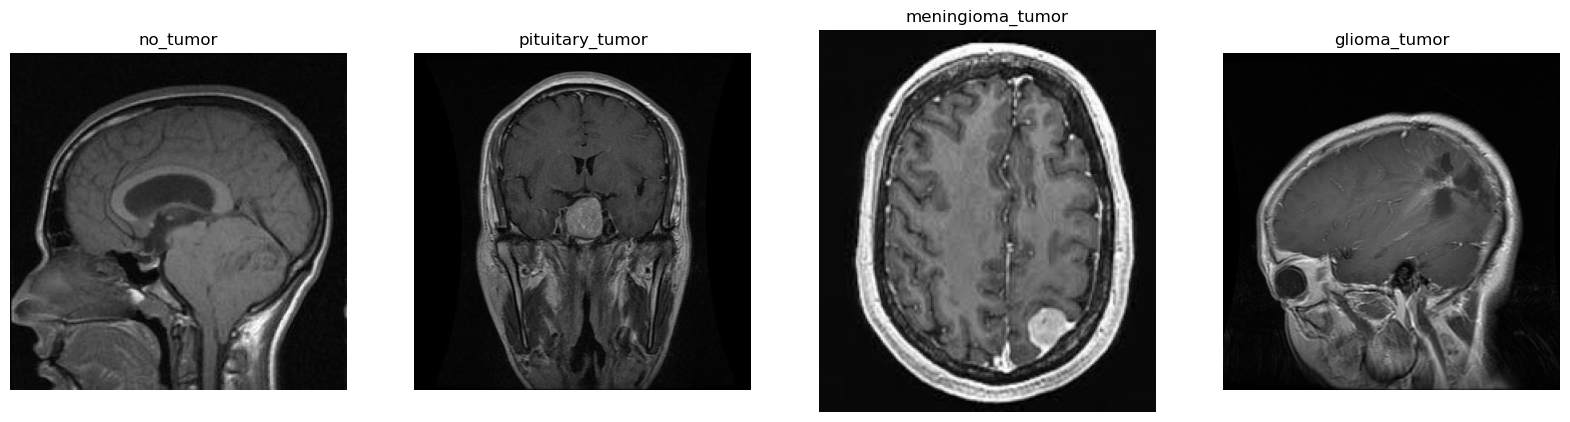

In [7]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [8]:
y_train

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
2865,1,0,0,0
2866,1,0,0,0
2867,1,0,0,0
2868,1,0,0,0


In [9]:
train_img_gray = tf.image.rgb_to_grayscale(train_img)
test_img_gray = tf.image.rgb_to_grayscale(test_img)

In [10]:
def get_model():
    data_augmentation = tf.keras.models.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(160, 160, 1)),
                                    tf.keras.layers.RandomRotation(0.1),
                                    tf.keras.layers.RandomZoom(0.1)])

    model = tf.keras.models.Sequential([data_augmentation,
                        tf.keras.layers.Rescaling(1./255, input_shape=(160, 160, 1)),
                        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                        tf.keras.layers.AveragePooling2D(),
                        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Conv2D(246, 3, padding='same', activation='relu'),
                        tf.keras.layers.AveragePooling2D(),
                        tf.keras.layers.Conv2D(20, 3, padding='same', activation='relu'),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(4, activation='softmax')
                       ])
    return model

In [11]:
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                      

In [12]:
epochs = 10
batch_size=32
history = model.fit(train_img_gray, y_train, validation_split=0.2,  epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1, workers=1)
# model.load_weights('tumor_model.h5')

Epoch 1/10
72/72 [==============================] - 36s 265ms/step - loss: 1.0329 - accuracy: 0.6389 - val_loss: 3.8347 - val_accuracy: 0.0000e+00
Epoch 2/10
72/72 [==============================] - 16s 224ms/step - loss: 0.6316 - accuracy: 0.7635 - val_loss: 8.8462 - val_accuracy: 0.0000e+00
Epoch 3/10
72/72 [==============================] - 16s 220ms/step - loss: 0.5542 - accuracy: 0.7909 - val_loss: 14.5424 - val_accuracy: 0.0000e+00
Epoch 4/10
72/72 [==============================] - 16s 226ms/step - loss: 0.5010 - accuracy: 0.8071 - val_loss: 14.0744 - val_accuracy: 0.0000e+00
Epoch 5/10
72/72 [==============================] - 16s 219ms/step - loss: 0.4527 - accuracy: 0.8354 - val_loss: 5.0866 - val_accuracy: 0.0000e+00
Epoch 6/10
72/72 [==============================] - 16s 221ms/step - loss: 0.4067 - accuracy: 0.8480 - val_loss: 5.2868 - val_accuracy: 0.0035
Epoch 7/10
72/72 [==============================] - 16s 223ms/step - loss: 0.3625 - accuracy: 0.8663 - val_loss: 1.3320 

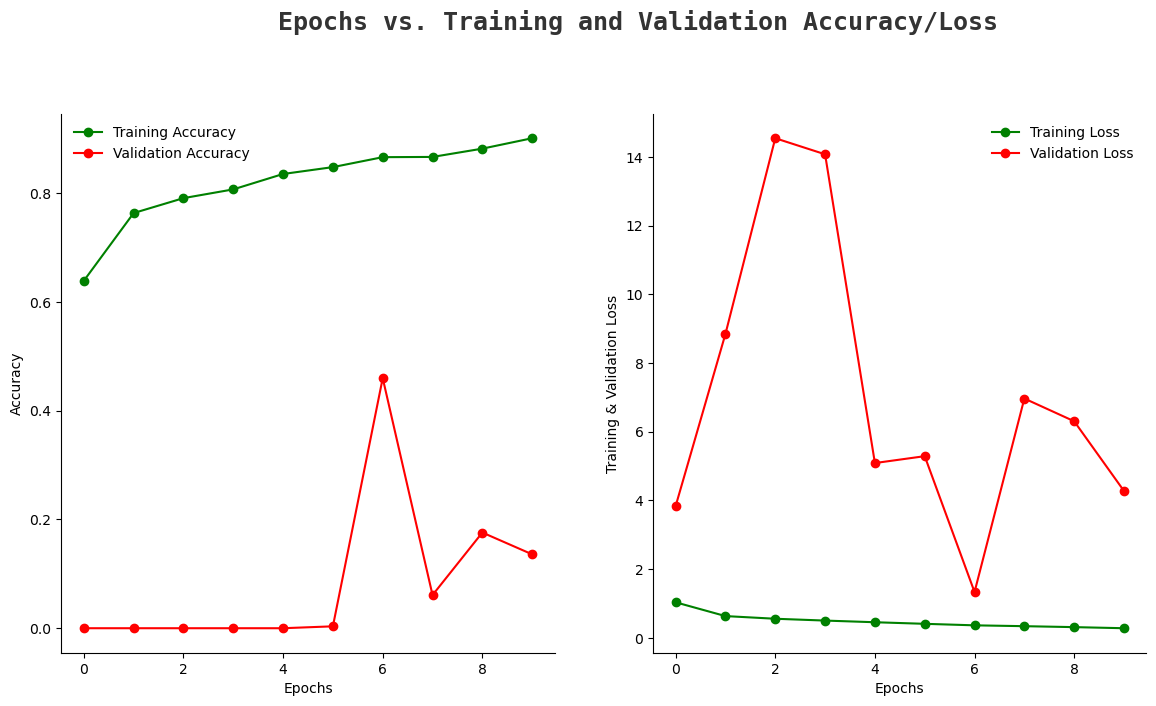

In [13]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor="g", color="g",
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor="r", color="r",
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor="g", color="g",
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor="r", color="r",
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [14]:
pred_prob = model.predict(test_img_gray)
pred = np.argmax(pred_prob,axis=1)
y_test_new = np.argmax(y_test.to_numpy(),axis=1)

13/13 [==============================] - 1s 77ms/step


In [15]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.75      0.03      0.06       100
           1       0.55      0.47      0.51       115
           2       0.35      0.92      0.51       105
           3       0.86      0.16      0.27        74

    accuracy                           0.42       394
   macro avg       0.63      0.40      0.34       394
weighted avg       0.61      0.42      0.35       394



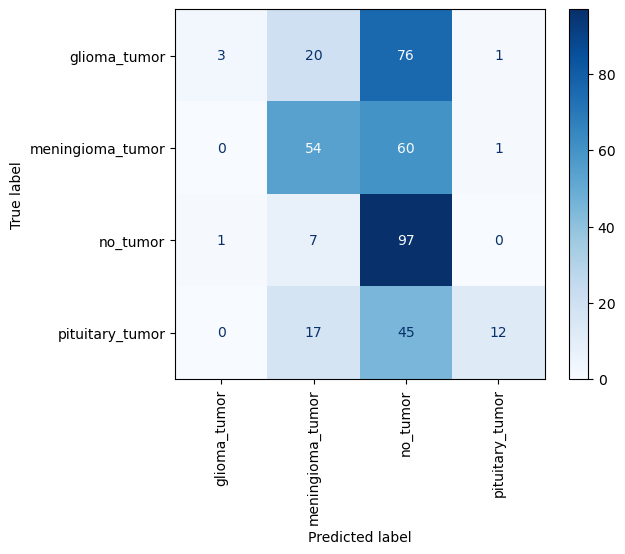

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred, display_labels=labels, 
                                        cmap='Blues', xticks_rotation="vertical")

In [43]:
model.save('2nd-model.h5')